# Introduction to Quantitative Finance

Copyright (c) 2019 Python Charmers Pty Ltd, Australia, <https://pythoncharmers.com>. All rights reserved.

<img src="img/python_charmers_logo.png" width="300" alt="Python Charmers Logo">

Published under the Creative Commons Attribution-NonCommercial 4.0 International (CC BY-NC 4.0) license. See `LICENSE.md` for details.

Sponsored by Tibra Global Services, <https://tibra.com>

<img src="img/tibra_logo.png" width="300" alt="Tibra Logo">


## Module 2.6: Overfitting

### 2.6.1 Problems with Overfitting

We reviewed overfitting and underfitting in previous modules. In this module we will cover overfitting in more detail. Underfitting is the case when your model is too simplistic to describe the data. For instance, trying to fit seasonal data with a linear regression model and no seasonal variables.

Overfitting is the opposite, when your model is *too* complicated for your data, leading to the model learning too much. This may not sound like a problem, but it leads to a situation where you have a very low error in your training data with a very **high** error in your testing data. The cause? Your model is learning the inherent noise in your dataset, that would be smoothed out or ignored in a simpler model.

This also explains why simpler models are often chosen for many problems. This whole series of modules has looked at linear models, ARIMA and GARCH as the main model types. Each of these is a fairly simple relationship of inputs to outputs. While you can use them in complicated ways, the simplicity of the models allows for noise to be smoothed out, and the underlying trends and concepts to be learned.

To see overfitting in data, fit a polynomial with a high degree to some linear data with noise:

In [1]:
%run setup.ipy

In [2]:
# y = mx + c + e
x = np.linspace(0, 10, 30)
error = np.random.randn(len(x)) * 5
y = x * 3 + 1 + error

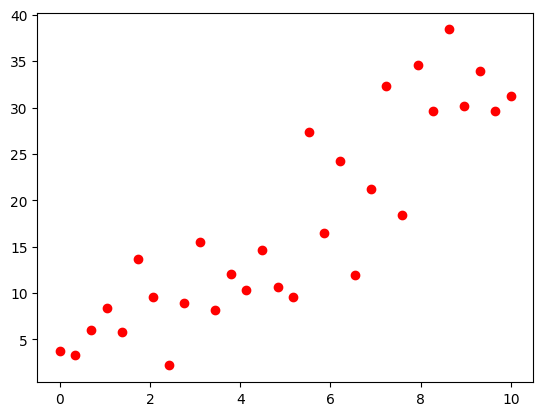

In [3]:
plt.plot(x, y, 'ro')

Here is what an appropriate model will find in this data:

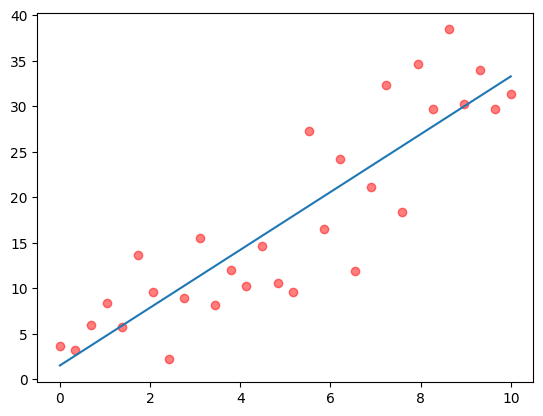

In [4]:
# Fit a linear model
params = np.polyfit(x, y, deg=1)
model = np.poly1d(params)

y_pred_linear = model(x)
plt.plot(x, y, 'ro', alpha=0.5)
plt.plot(x, y_pred_linear)

Here is a model that is overfitting:

In [5]:
# Fit a polynomial with degree 30!
params_30 = np.polyfit(x, y, deg=10)

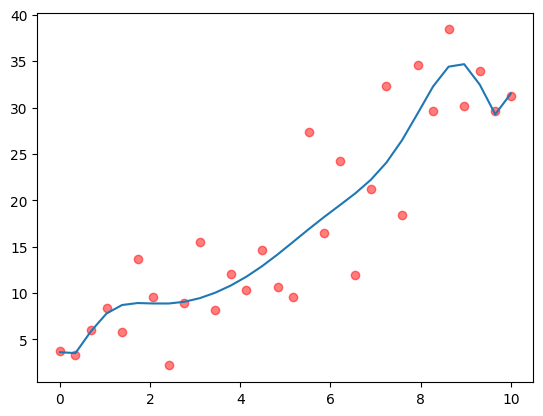

In [6]:
model_30 = np.poly1d(params_30)

y_pred_overfit = model_30(x)
plt.plot(x, y, 'ro', alpha=0.5)
plt.plot(x, y_pred_overfit)

Note how, even though there is a clear linear trend, the line-of-"best"-fit wobbles through the data? The model has too much freedom, and ends up trusting the data too much.



#### Exercise

To see the effect of overfitting, let's create a new dataset using the same formula as before, and compute the difference in SSE (sum squared error) for both models.

1. Create new data by choosing 50 points randomly from 0 to 100 (see `np.random.random`)
2. Create new y values with random error from the same distribution we originally created `y` from (same error, same m and c values)
3. Compute the training error. That is, the difference between `y_pred_linear` and `y`, and the difference between  `y_pred_overfit` and `y`. Which model has a lower training error?
4. Retrain the model with a sample from the training data. Notice how the parameters change significantly as you keep sampling the data. 

The results you see in this exercise are also shown if you were to choose another sample from the original dataset. In other words, this model is not stable because it is overfitting.

779.7522825656653 591.0643051438749
7050.380179325607 1.3073319679258988e+31


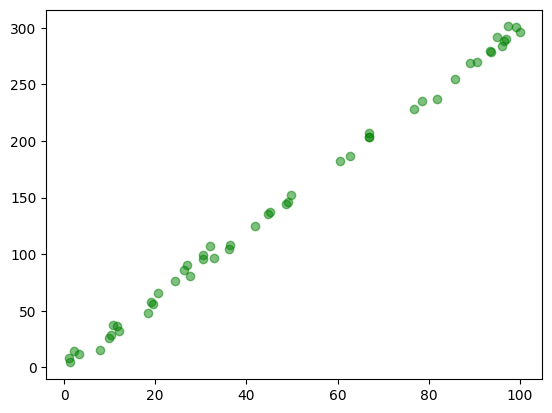

In [15]:
# From the solutions, overfitting will obviously perform poorly on the test set compared to a simpler model.
# 50 points randomly from 0 to 100
x_test = np.random.random(50) * 100
error_test = np.random.randn(len(x_test)) * 5
y_test = x_test * 3 + 1 + error_test

# Training errors
SSE_linear = np.sum((y_pred_linear - y) ** 2)
SSE_overfit = np.sum((y_pred_overfit - y) ** 2)

print(SSE_linear, SSE_overfit)  # Overfit is lower for training error

plt.plot(x_test, y_test, 'go', alpha=0.5)

y_est_linear = model(x_test)
y_est_poly = model_30(x_test)

# Training errors
SSE_est_linear = np.sum((y_est_linear - y_test) ** 2)
SSE_est_overfit = np.sum((y_est_poly - y_test) ** 2)

print(SSE_est_linear, SSE_est_overfit)  # SSE is **very** high for the overfit model.

*For solution see `solutions/overfitting_one.py`*

### Overfitting with too many variables

Overfitting can be caused by a large number of factors. In the above, overfitting was caused by the model being too complex. Overfitting can also happen when you have too many input variables, even if some of them are just random noise!

What happens in this case, is that unusual patterns are picked up in the data, leading to pattern matching algorithms (of which all the algorithms we have seen so far are) finding patterns in noise, rather than underlying trends. It results in the same problem overly-complex models do - low training error, high testing error. The cause this time is that the coincidental patterns in the training data are usually not present in the testing data, so they no longer work.

This is a case of spurious correlations. For a humorous look at this problem, see http://www.tylervigen.com/spurious-correlations

![Spurious Correlation](img/spurious.png)

<small>Note: The above data has a correlation $r=0.95$</small>

If you compare enough variables, you *will* find a correlation. Whether that makes sense or not is your job as an analyst. 

All too often in the "big data" age, we simply think "add more data until the computer learns", but the actual case is the opposite - too much data leads to incorrect learning and wasted effort.

To see this in action, we'll download all stock prices for the S&P500, and then use those to predict AAPL:

In [16]:
# Let's extract a large number of stocks
import quandl
import my_secrets
quandl.ApiConfig.api_key = my_secrets.QUANDL_API_KEY

In [17]:
with open("data/sp500.csv") as inf:
    stocks = inf.readlines()[1:]  # Skip header
    # Remove whitespace around stocks, ignore empty lines (like the last one)
    stocks = [stock.strip() for stock in stocks if stock.strip()]

In [18]:
stocks[:5]

['MMM', 'ABT', 'ABBV', 'ABMD', 'ACN']

In [19]:
import time

# Too many to download in one go - get in batches instead
batches = []
batch_size = 10

for i in range(0, len(stocks), batch_size):
    print("Downloading batch {}".format(i))
    current_batch = quandl.get_table('WIKI/PRICES', ticker = stocks[i:i+batch_size], 
                            qopts = { 'columns': ['ticker', 'date', 'adj_close'] }, 
                            date = { 'gte': '2017-01-01', 'lte': '2019-01-01' }, 
                            paginate=True)
    batches.append(current_batch)
    time.sleep(1)

In [20]:
current_batch.head()

,ticker,date,adj_close
None,,,
0,ZTS,2018-03-27,81.86
1,ZTS,2018-03-26,83.73
2,ZTS,2018-03-23,80.60
3,ZTS,2018-03-22,82.06
4,ZTS,2018-03-21,84.10


In [28]:
data = pd.concat(batches)

In [29]:
stocks = data.pivot(index="date", columns="ticker", values="adj_close")
# Fill any missing data using a forward fill
stocks.fillna(method='ffill', inplace=True)

In [30]:
stocks.index.min(), stocks.index.max()

(Timestamp('2017-01-03 00:00:00'), Timestamp('2018-03-27 00:00:00'))

In [31]:
stock_to_predict = "AAPL"
X = stocks[[column for column in stocks.columns if column != stock_to_predict]]
y = stocks[stock_to_predict]

In [32]:
split_date = "2018-01-01"
X_train, X_test = X[:split_date], X[split_date:]
y_train, y_test = y[:split_date], y[split_date:]

We've seen a few methods of doing linear regression now. Use the one you are more comfortable with. Here, we will use sklearn:

In [33]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

One problem - sklearn doesn't handle NaN values - missing data - very well.

In [34]:
# Here are the culprits:
is_missing = X_train.isna().any()
missing = is_missing[is_missing]  # only show the Trues
missing

ticker
APTV    True
BHGE    True
BKNG    True
CBRE    True
DWDP    True
DXC     True
HLT     True
INFO    True
IQV     True
TPR     True
WELL    True
dtype: bool

In [35]:
stocks_cleaned = stocks[[column for column in stocks.columns if column not in missing.index]]

In [37]:
stock_to_predict = "AAPL"
# Also skip the ones in our missing model
X = stocks_cleaned.drop(stock_to_predict, axis=1)  # Drop the column, in a VIEW of the original data
y = stocks_cleaned[stock_to_predict]

In [38]:
split_date = "2018-01-01"
X_train, X_test = X[:split_date], X[split_date:]
y_train, y_test = y[:split_date], y[split_date:]

In [39]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

In [40]:
y_train_pred = model.predict(X_train)

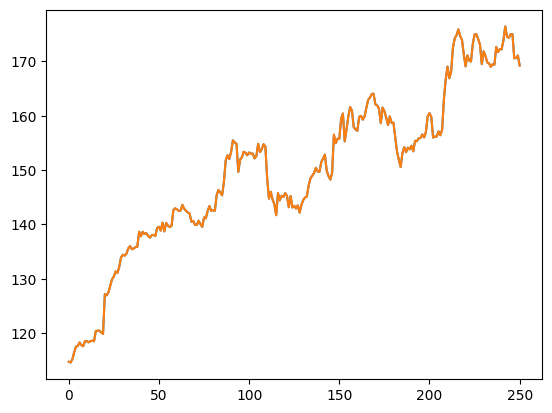

In [41]:
plt.plot(y_train_pred)
plt.plot(y_train.values)

With *so much* data to use, our predictions are nearly perfect on our training data. Can't see it? Try plotting `plt.plot(y_train.values + 1)`. This near-perfectness is due to the ability of the Linear model to pick and choose the data that best fits it, and it can just keep doing this until it matches as best as it could.

However good this model is on the training data, it fails on the testing data:


In [42]:
y_test_pred = model.predict(X_test)

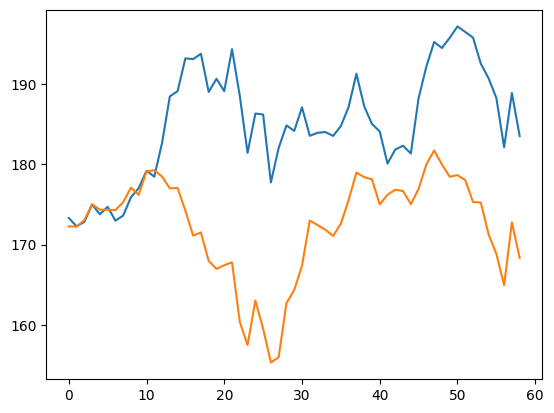

In [43]:
plt.plot(y_test_pred)
plt.plot(y_test.values)

To detect overfitting, one method is to use a validation curve. This marks "complexity" as the x-axis, and plots training and testing scores. Typically, the two curves start apart (underfitting), converge, then diverge again as overfitting kicks in.


In [44]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

The above code uses a scikit-learn Pipeline to create a `degree`-dimensional copy of all features. For instance, `x` with degree 3 returns features $x$, $x^2$, and $x^3$ (and $c$). A linear regression is then fit on these models.

[3, 2, 5, 3, 3]


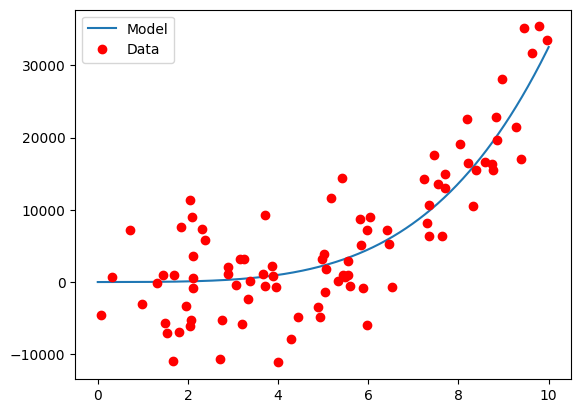

In [45]:
# Create a dataset
params = [3, 2, 5, 3, 3]  # 5 random numbers - 5 degree polynomial
model = np.poly1d(params)
print(params)

x_model = np.linspace(0, 10, 1000)  # x-spaced data
y_model = model(x_model)   # Actual y values
plt.plot(x_model, y_model, label='Model')

x = (np.random.random(90) * 10)  # 1000 random points between 0 and 10, in a 2D matrix
y = model(x) + np.random.randn(len(x)) * 5000  # Use the model, but  with noise
plt.plot(x, y, 'ro', label="Data")
plt.legend()

In [46]:
from sklearn.model_selection import validation_curve

def rms_error(model, X, y):
    y_pred = model.predict(X)
    return np.sqrt(np.mean((y - y_pred) ** 2))

x = x.reshape(-1, 1)  # Make 2D matrix, as required by sklearn
degree = np.arange(0, 20)
val_train, val_test = validation_curve(PolynomialRegression(), x, y,
                                       'polynomialfeatures__degree', degree, cv=7,
                                       scoring=rms_error)

TypeError: too many positional arguments

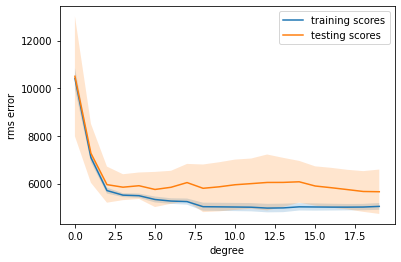

In [36]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

plot_with_err(degree, val_train, label='training scores')
plot_with_err(degree, val_test, label='testing scores')
plt.xlabel('degree'); plt.ylabel('rms error')
plt.legend();

Note in the above, that the errors start to diverge around degree 5. This is a little "late" (I would choose degree = 3 based on this graph), but it gives a sense that values any higher are overfitting. This is because the training and testing scores are diverging after this point.

With graphs like these, you can reduce the overall training error with more data, and you can make the graphs converge with a better fitting model.

Note that once you use testing data to do any training, it can't be used for evaluation. In this case, we would be using our test set to decide the degree of the polynomial. After this point, that testing data has been used in training, and you would need *more* data to give a proper evaluation of the expected performance of the model.

Note that, as we have seen, overfitting can happen if your model is too complex, or if you have too many variables, or - as we saw above - too many variants of specific variables. Keep the theory in mind - before adding to a model, ensure you have a good theoretic reason for doing so.

#### Exercise

1. Using "number of other stocks" as the "degree", fit the AAPL price to a number of random stocks. Keep the "random" stocks consistent throughout the testing though! After how many stocks do we start overfitting?
2. A similar experiment can be performed with "number of data points" on the x-axis and train/test error. Create this plot, varying the size of the dataset. This plot tells us whether collecting more data will assist or not with improving the error, which can be critical in determining if funds need to be spent in this area.

### Linear Regression vs Ridge Regression

One example of an algorithm that can reduce the problem of overfitting is Ridge Regression. It can be summarised as "Linear Regression, but you are penalised for high $\beta$ values". Ridge Regression helps when your overfitting problem is caused by too many variables (not so much for model complexity). There are several algorithms of this type, that penalise attributes that could cause overfitting.

Given the normal $SSE$ value that Linear Regression models minimise, Ridge Regression instead aims to minimise:

$SSE_R = SSE + \lambda m^2$

Where $m$ is the slope of the curve (or the sum of slopes of curves), and $\lambda$ is a tunable parameter. Setting it high penalises high slopes, leading to "flatter" models being learned. If $\lambda=0$, then the algorithm is exactly the same as a Linear Regression. 

Generally, you would fit $\lambda$ to your data using a cross-fold validation to choose the best value.

As an interesting, if perhaps not useful sidenote, Ridge Regression can also fit with as little as one data point. Linear Regression cannot, because there are infinite lines going through a single point, and any of them minimise $SSE$. However, only one minimises $SSE_R$ (when $\lambda > 0$).

#### Exercise

1. Fit Linear Regression and Ridge Regression to a small dataset, with a positive, non-zero $\lambda$ value and compare the lines of best fit.
2. Investigate Grid Search in scikit-learn, and use it to fit the best value of $\lambda$.

*For solutions, see `solutions/overfitting_three.py`*